# Влияние маркетинговых акций и истории потребления на конверсию в покупку

Контекст

Маркетинговая рекламная кампания
с общим количеством данных 6 400 клиентов.

Содержание:
Этот набор данных показывает краткую информацию о клиенте,
историческое использование скидки или акции BOGO(Buy One Get One),
предложение было сделано, и результат конверсии (купил или нет).
Среднее значение конверсии = $25

Переменные: 

recency - месяцы с момента последней покупки

history - стоимость покупок за прошлые периоды

used_discount - указывает, использовал ли покупатель скидку ранее

used_bogo - указывает, использовал ли покупатель ранее buy one get one

zip_code - класс почтового индекса как пригород/город/сельская местность

is_referral - указывает, был ли клиент приобретен по реферальному каналу

channel - каналы, которые использовал клиент, телефон/веб/мультиканал

offer - предложения, отправленные клиентам, cкидка/gолучить одно/без предложения 

conversion - конверсия клиента (купил или нет)

Импортируем бибилиотеки

In [18]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import scipy as scipy
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.preprocessing import StandardScaler
import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import confusion_matrix,plot_confusion_matrix, plot_roc_curve, precision_score, recall_score , accuracy_score, f1_score

In [19]:
df = pd.read_csv('data.csv') #загружаем данные
df.head() 

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [20]:
df.info() #видим что датасет не имеет пропущенных значений

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


### Визуализация

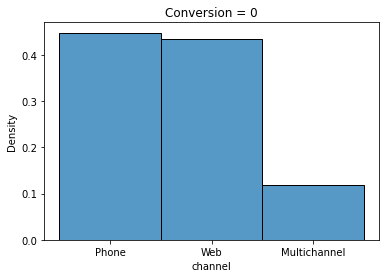

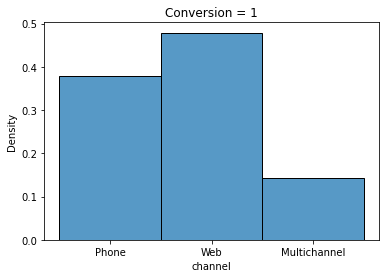

In [21]:
# смотрим как различаются конверсии в зависимости от канала
sns.histplot(data = df[df['conversion'] == 0], x = 'channel' , stat = 'density').set(title='Conversion = 0')
plt.show()
sns.histplot(data = df[df['conversion']== 1], x = 'channel' , stat = 'density').set(title='Conversion = 1')
plt.show()


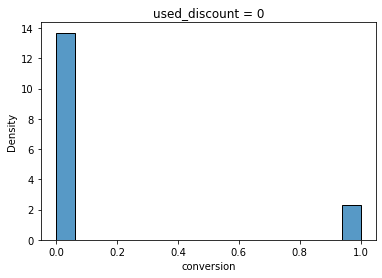

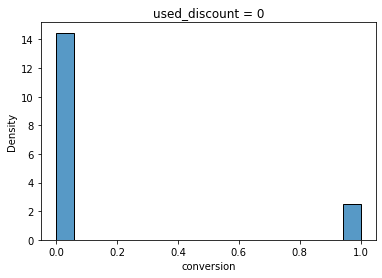

In [22]:
#Смотрим конверсии в разрезе использования скидок

sns.histplot(data = df[df['used_discount'] == 0], x = 'conversion' , stat = 'density').set(title='used_discount = 0')
plt.show()
sns.histplot(data = df[df['used_discount'] == 1], x = 'conversion' , stat = 'density').set(title='used_discount = 0')
plt.show()

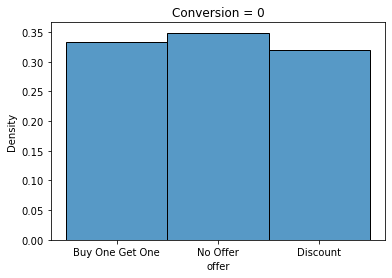

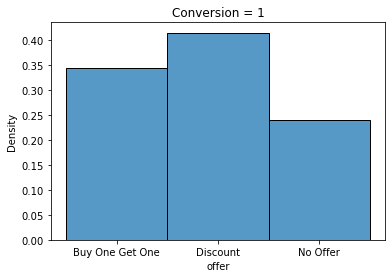

In [23]:
#Смотрим в разрезе типов акций

sns.histplot(data = df[df['conversion'] == 0], x = 'offer' , stat = 'density').set(title='Conversion = 0')
plt.show()
sns.histplot(data = df[df['conversion']== 1], x = 'offer' , stat = 'density').set(title='Conversion = 1')
plt.show()

/Users/vika/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Violinplot')]

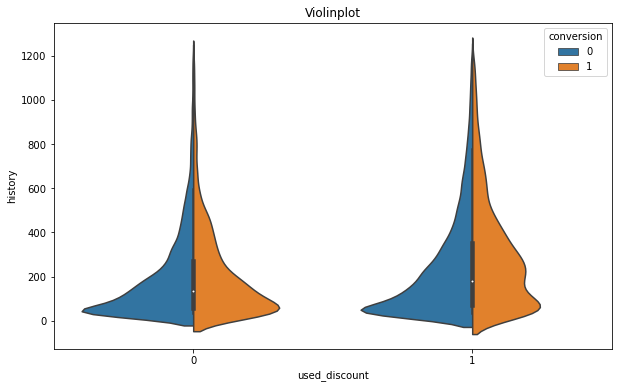

In [24]:
plt.figure(figsize=(10,6))
sns.violinplot('used_discount','history',data=df[df['history']< 1200], hue = 'conversion', split= True).set(title='Violinplot')

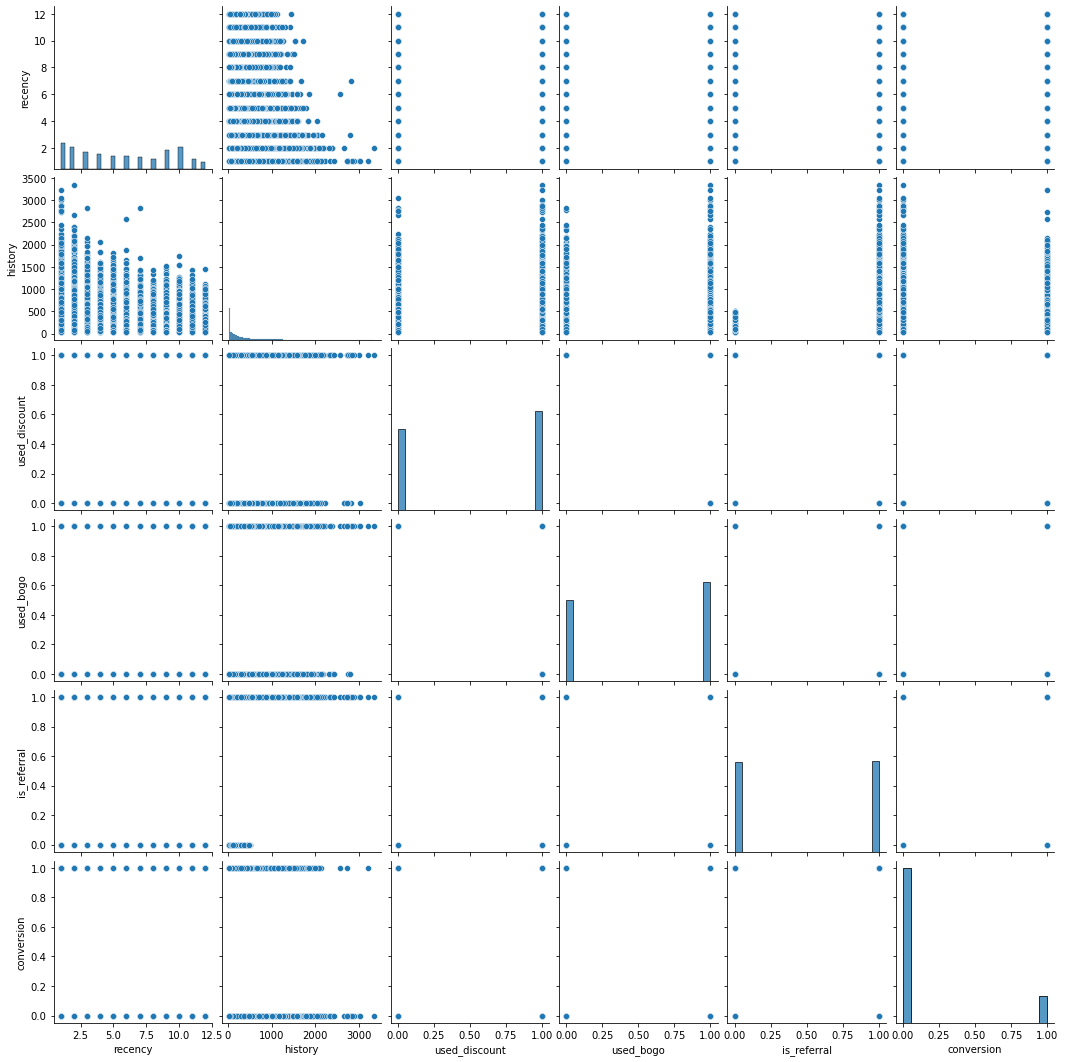

In [25]:
sns.pairplot(data=df)

### Сделаем предположение, что конверсия не зависит от канала


#### H0: Не существует зависимости между каналом и конверсией в покупку

#### H1: Существует стат. значимая зависимость между каналом и конверсией в покупку

In [26]:
#Для проверки гипотезы используем критерий хи-квадрат

hyp_1 = df.groupby('channel')['conversion'].value_counts().unstack()
chi_2, p_val, dn, expected = scipy.stats.chi2_contingency(hyp_1, correction = False)

output = "chi_2: {}\ndegrees of freedom: {}\np-value: {}\n"
print(output.format(chi_2,dn, p_val))

alpha = 0.05 
critical_value = scipy.stats.chi2.ppf(0.95, dn)
print(critical_value)

if chi_2 >= critical_value:   #Проверяем H0
    print('Отвергаем Н0')
else:
    print('Не отвергаем Н0')

chi_2: 160.69711674409655
degrees of freedom: 2
p-value: 1.2736921440078863e-35

5.991464547107979
Отвергаем Н0


### Отвергаем H0 - существует статистически значимая зависимость между каналом и конверсией

### Сделаем предположение, что наличие скидки не влияет на конверсию
#### H0: Не существует зависимости между скидкой и конверсией
#### H1: Существует стат. значимая зависимость между скидкой и конверсией

In [27]:
hyp_2 = df.groupby('used_discount')['conversion'].value_counts().unstack()
chi_2, p_val, dn, expected = scipy.stats.chi2_contingency(hyp_2, correction = False)

output = "chi_2: {}\ndegrees of freedom: {}\np-value: {}\n"
print(output.format(chi_2,dn, p_val))

alpha = 0.05 
critical_value = scipy.stats.chi2.ppf(0.95, dn)
print (critical_value)

if chi_2 >= critical_value:   #Проверяем H0
    print('Отвергаем Н0')
else:
    print('Не отвергаем Н0')

chi_2: 2.8832558895348677
degrees of freedom: 1
p-value: 0.08950487803670254

3.841458820694124
Не отвергаем Н0


### Не отвергаем Н0 - нет зависимости между наличием скидки и конверсией в покупку

### Сделаем предположение, что тип акции не влияет на конверсию
#### H0: Не существует зависимости между типом акции и конверсией
#### H1: Существует стат. значимая зависимость между типом акции и конверсией

In [28]:
hyp_3 = df.groupby('offer')['conversion'].value_counts().unstack()


chi_2, p_val, dn, expected = scipy.stats.chi2_contingency(hyp_3, correction = False)

output = "chi_2: {}\ndegrees of freedom: {}\np-value: {}\n"
print(output.format(chi_2,dn, p_val))

alpha = 0.05 
critical_value = scipy.stats.chi2.ppf(0.95, dn)
print (critical_value)

if chi_2 >= critical_value:   #Проверяем гипотезу
    print('Отвергаем Н0')
else:
    print('Не отвергаем Н0')

chi_2: 504.46066903563496
degrees of freedom: 2
p-value: 2.869178384267155e-110

5.991464547107979
Отвергаем Н0


### Отвергаем Н0 - есть зависимость между типом акции и конверсией

### Проверим как сумма предыдущих покупок (history) влияет на конверсию

Используем модель логистической регрессии, тк конверсия выражена категориальной бинарной переменной.

In [29]:
x = df[['history']].apply(stats.zscore) #нормируем
y = df['conversion']

logr = sm.Logit(y, x)
log_res = logr.fit()
print(log_res.summary())

Optimization terminated successfully.
         Current function value: 0.692079
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:             conversion   No. Observations:                64000
Model:                          Logit   Df Residuals:                    63999
Method:                           MLE   Df Model:                            0
Date:                Wed, 14 Dec 2022   Pseudo R-squ.:                 -0.6593
Time:                        22:31:22   Log-Likelihood:                -44293.
converged:                       True   LL-Null:                       -26693.
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
history        0.0930      0.008     11.618      0.000       0.077       0.109


Мы видим что есть стат. значимые зависимость конверсии в покупку от суммы предыдущих покупок. Однако эта зависимость выражена слабо. Сама зависимость говорит о том, что чем больший опыт покупок мы имеем (больше денег потрачено), тем выше вероятность покупки.

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=35) #сделаем тестовую и обущающую выборки

logm = LogisticRegression( class_weight = 'balanced') 
logm.fit(x_train, y_train) #тренируем модель
y_pred = logm.predict(x_test)  #генерируем прогноз

#Проверим качество модели
print('Accuracy :', accuracy_score(y_test, y_pred))  
print('F1_score: ', f1_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))  




Accuracy : 0.642875
F1_score:  0.24835569586950798
Precision:  0.18018705859896927
Recall:  0.39949217096910705


/Users/vika/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


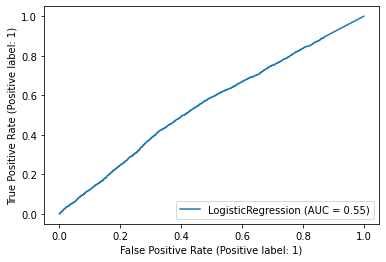

In [31]:
plot_roc_curve(logm, x_test, y_test) #ROC-кривая, показывающая связь чувствительности и специфичности модели



/Users/vika/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


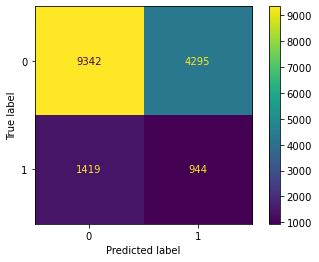

In [32]:
plot_confusion_matrix(logm, x_test, y_test) #матрица ошибок.

Опираясь на метрики выше можем заключить, что наша модель логистической регрессии имеет низкую предсказательную силу, для более точного предсказания необходимо выбрать более продвинутые модели и/или расширить число переменных.

В данной работе было проверено 3 гипотезы с помощью критерия хи-квадрат. Была обнаружена зависимость между каналом продаж (тип устройства) и конверсией в покупку. Наличие данной зависимости можно объяснить различными ситуациями, в которых используются разные устройства. Также было подтверждено отсутствие зависимости между использованием скидки в прошлом и конверсией в покупку. В то же время было обнаружено, что тип акции, предложенный клиенту, влияет на конверсию в покупку. 

Также мы исследовали, как влияет сумма предыдущих покупок на конверсию в покупку. Для этого мы построили модель логистической регрессии. Была обнаружена положительная стат. значимая связь между суммой предыдущих покупок и покупкой. Однако построенная предсказательная модель на основе логистической регрессии показала низкую предсказательную силу. Для более точного предсказания конверсии в покупку стоит выбрать другую модель (например Random Forest модели) и расширить пулл независимых переменных.